In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Import Libraries**

We have to use GroupNormalization in model architecture so we should install tensorflow addons to import GroupNormalization from it.

In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.0 MB/s eta 0:00:00


In [77]:
from tensorflow_addons.layers import GroupNormalization
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, LeakyReLU, UpSampling2D, Multiply, Add, MaxPool2D, AveragePooling2D, Concatenate
import os
import random
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use("ggplot")
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from sklearn.model_selection import train_test_split
import albumentations as A
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow import reduce_sum
from tensorflow.keras import backend as K

#**Download the data**

In [3]:
!curl -O https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  46.0M      0  0:00:16  0:00:16 --:--:-- 52.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  41.2M      0 --:--:-- --:--:-- --:--:-- 41.2M


#**Prepare and visualize Data**

In [57]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


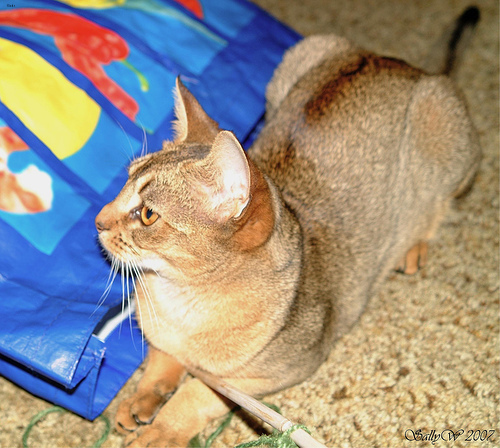

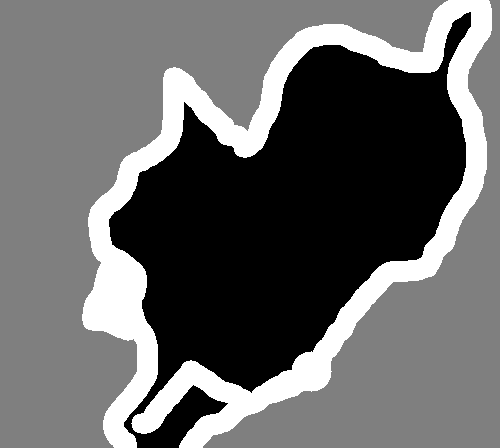

In [58]:
# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

#**Data Generator**

In [59]:
class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

#**Model**

I used SD_UNet model for this task. I implemented this model a few month ago. You can find the paper by searching: "sd-unet: a novel segmentation framework for ct images of lung infections".

In [7]:
def conv_block(num_filters: int, input: tf.Tensor, kernel_size=3, dilation_rate=1) -> tf.Tensor:
  """
  Buld a simple block which will use many times in model architecture
  args:
    num_filters: Depth of convolution layer.
    input: Tensor.
    kernel_size: Size of kernels in convolution layer.
    dilation_rate: Rate of dilation.
    
  return:
    x: Tensor.
  """
  x = Conv2D(num_filters, kernel_size=kernel_size, strides=(1, 1), dilation_rate=dilation_rate ,padding="same", use_bias=True)(input)
  x = GroupNormalization(groups=32)(x)
  x = LeakyReLU()(x)
  return x

In [8]:
def sa_block(num_filters: int, x: tf.Tensor) -> tf.Tensor:
  """
  Build a squeez and attention (SA) block which was introduced in paper.
  args:
    num_filters: Depth of convolution layer.
    input: Tensor.
  
  return:
    x: Tensor.
  """
  x_res = conv_block(num_filters, x)
  y_res = conv_block(num_filters, x_res)
  x_atten = AveragePooling2D(pool_size=2, strides=2)(x)
  x_atten = conv_block(num_filters, x_atten)
  x_atten = conv_block(num_filters, x_atten)
  y_atten = UpSampling2D(size=(2, 2))(x_atten)
  out_1 = Multiply()([y_atten, y_res])
  out = Add()([out_1, y_atten])
  return out

In [9]:
def downsample_block(num_filters: int, x: tf.Tensor) -> tf.Tensor:
  """
  Build a down sample block. this block will be used in encoder part.
  arg:
    num_filters: Depth of convolution layer.
    input: Tensor.

  return:
    x: Tensor.
  """
  x1 = MaxPool2D(pool_size=(2, 2), strides=2)(x)
  x2 = AveragePooling2D(pool_size=(2, 2), strides=2)(x)
  x = Concatenate(axis=-1)([x1, x2])
  x = conv_block(num_filters, x, kernel_size=1)
  return x

In [10]:
def upsample_block(num_filters: int, x: tf.Tensor) -> tf.Tensor:
  """
  Build a up sample block. This block will be used in decoder part.
  args:
    num_filters: Depth of convolution block.
    input: Tensor.

  return:
    x: Tensor.
  """
  x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
  x = conv_block(num_filters, x, kernel_size=1)
  return x

In [11]:
def daspp(input: tf.Tensor) -> tf.Tensor:
    """
    Build Dense Atrous Spatial Pyramid Pooling(DASPP) block. 
    This block will be used in the bottleneck between encoder and decoder.
    arg:
      input: Tensor.

    return:
      output: Tensor.
    """
    dims = input.shape
    x = AveragePooling2D(pool_size=(dims[-3], dims[-2]))(input)
    x = conv_block(num_filters=256, input=x, kernel_size=1)
    out_pool = UpSampling2D(
          size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
          interpolation="bilinear")(x)
    out_1 = conv_block(num_filters=256, input=input, kernel_size=1, dilation_rate=1)
    out_6 = conv_block(num_filters=256, input=input, kernel_size=3, dilation_rate=6)
    x_12 = Concatenate(axis=-1)([input, out_6])
    out_12 = conv_block(num_filters=256, input=x_12, kernel_size=3, dilation_rate=12)
    x_18 = Concatenate(axis=-1)([input, x_12, out_12])
    out_18 = conv_block(num_filters=256, input=x_18, kernel_size=3, dilation_rate=18)
    x = Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = conv_block(num_filters=256, input=x, kernel_size=1)
    return output

In [12]:
def sd_unet(num_class: int, input_size=(160, 160, 3)) -> tf.Tensor:
    """
    Build sd_unet model.
    args: 
      num_class: Number of classes.
      input_size: Size of entery images.
    return:
      out: The model's predicted mask for input.
    """
    # Encoder
    input = keras.Input(input_size)
    x1 = sa_block(32, input)
    x2 = downsample_block(32, x1)
    x3 = sa_block(64, x2)
    x4 = downsample_block(64, x3)
    x5 = sa_block(128, x4)
    x6 = downsample_block(128, x5)
    x7 = sa_block(256, x6)
    x8 = downsample_block(256, x7)
    x9 = sa_block(512, x8)
    # Bottleneck
    x10 = daspp(x9)
    # Decoder
    x11 = upsample_block(256, x10)
    x12 = Concatenate(axis=-1)([x11, x7])
    x13 = sa_block(256, x12)
    x14 = upsample_block(128, x13)
    x15 = Concatenate(axis=-1)([x14, x5])
    x16 = sa_block(128, x15)
    x17 = upsample_block(64, x16)
    x18 = Concatenate(axis=-1)([x17, x3])
    x19 = sa_block(64, x18)
    x20 = upsample_block(32, x19)
    x21 = Concatenate(axis=-1)([x20, x1])
    x22 = sa_block(32, x21)

    if num_class == 2:
      activation = 'sigmoid'
    else:
      activation = 'softmax'
    output = Conv2D(filters=num_class, kernel_size=3, padding="same", use_bias=True, activation=activation)(x22)
    return keras.Model(inputs=input, outputs=output, name="SD_UNet")

In [ ]:
model = sd_unet(num_class=3)
model.summary()

In [108]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 average_pooling2d (AverageP  (None, 80, 80, 3)        0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 80, 32)        896       
                                                                 
 group_normalization_2 (Grou  (None, 80, 80, 32)       64        
 pNormalization)                                                 
                                                                 
Total params: 960
Trainable params: 960
Non-trainable params: 0
_________________________________________________________________


#**Split data**

In [60]:
# Split our img paths into a training and a validation set
val_samples = 900
test_samples = 100
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples-test_samples]
train_target_img_paths = target_img_paths[:-val_samples-test_samples]
val_input_img_paths = input_img_paths[-val_samples:-test_samples]
val_target_img_paths = target_img_paths[-val_samples:-test_samples]
test_input_img_paths = input_img_paths[-test_samples:]
test_target_img_paths = target_img_paths[-test_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
test_gen = OxfordPets(batch_size, img_size, test_input_img_paths, test_target_img_paths)

#**Train the model**

In [18]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/oxford_segmentation.h5", save_best_only=True),
    EarlyStopping(
                  monitor="val_loss",
                  patience=5,
                  verbose=0,
)
]

# Train the model, doing validation at the end of each epoch.
epochs = 30
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/30
199/199 [==============================] - 258s 967ms/step - loss: 0.6554 - val_loss: 0.5145
Epoch 2/30
199/199 [==============================] - 191s 957ms/step - loss: 0.4933 - val_loss: 0.4525
Epoch 3/30
199/199 [==============================] - 191s 958ms/step - loss: 0.4282 - val_loss: 0.3943
Epoch 4/30
199/199 [==============================] - 194s 975ms/step - loss: 0.3902 - val_loss: 0.3852
Epoch 5/30
199/199 [==============================] - 191s 957ms/step - loss: 0.3642 - val_loss: 0.3403
Epoch 6/30
199/199 [==============================] - 194s 974ms/step - loss: 0.3408 - val_loss: 0.3252
Epoch 7/30
199/199 [==============================] - 191s 957ms/step - loss: 0.3231 - val_loss: 0.3211
Epoch 8/30
199/199 [==============================] - 192s 964ms/step - loss: 0.3099 - val_loss: 0.3228
Epoch 9/30
199/199 [==============================] - 190s 956ms/step - loss: 0.2970 - val_loss: 0.2995
Epoch 10/30
199/199 [==============================] - 188s 945m

In [109]:
model = keras.models.load_model("/content/drive/MyDrive/oxford_segmentation.h5")

In [111]:
layer_number

[3]

In [110]:
model.summary()

Model: "SD_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 average_pooling2d (AveragePool  (None, 80, 80, 3)   0           ['input_1[0][0]']                
 ing2D)                                                                                           
                                                                                                  
 conv2d_2 (Conv2D)              (None, 80, 80, 32)   896         ['average_pooling2d[0][0]']      
                                                                                            

In [113]:
layer_number

[3,
 5,
 8,
 11,
 21,
 25,
 27,
 30,
 33,
 43,
 47,
 49,
 52,
 55,
 65,
 69,
 71,
 74,
 77,
 87,
 91,
 93,
 96,
 99,
 106,
 110,
 114,
 117,
 118,
 126,
 130,
 135,
 137,
 140,
 143,
 151,
 156,
 158,
 161,
 164,
 172,
 177,
 179,
 182,
 185,
 193,
 198,
 200,
 203,
 206,
 213]

In [132]:
i = 0
layer_number = []
for layer in model.layers:
 # check for convolutional layer
  i += 1
  if 'conv' not in layer.name:
    continue
 # get filter weights
  filter, bias = layer.get_weights()
  layer_number.append(i)
  print(f'number of conv in order of layers is: {i+1}\n', layer.name, filter.shape, bias.shape)

number of conv in order of layers is: 4
 conv2d_2 (3, 3, 3, 32) (32,)
number of conv in order of layers is: 6
 conv2d (3, 3, 3, 32) (32,)
number of conv in order of layers is: 9
 conv2d_3 (3, 3, 32, 32) (32,)
number of conv in order of layers is: 12
 conv2d_1 (3, 3, 32, 32) (32,)
number of conv in order of layers is: 22
 conv2d_4 (1, 1, 64, 32) (32,)
number of conv in order of layers is: 26
 conv2d_7 (3, 3, 32, 64) (64,)
number of conv in order of layers is: 28
 conv2d_5 (3, 3, 32, 64) (64,)
number of conv in order of layers is: 31
 conv2d_8 (3, 3, 64, 64) (64,)
number of conv in order of layers is: 34
 conv2d_6 (3, 3, 64, 64) (64,)
number of conv in order of layers is: 44
 conv2d_9 (1, 1, 128, 64) (64,)
number of conv in order of layers is: 48
 conv2d_12 (3, 3, 64, 128) (128,)
number of conv in order of layers is: 50
 conv2d_10 (3, 3, 64, 128) (128,)
number of conv in order of layers is: 53
 conv2d_13 (3, 3, 128, 128) (128,)
number of conv in order of layers is: 56
 conv2d_11 (3, 3, 1

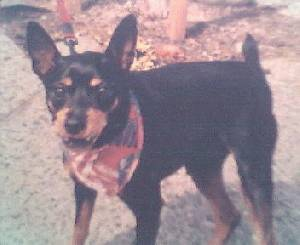

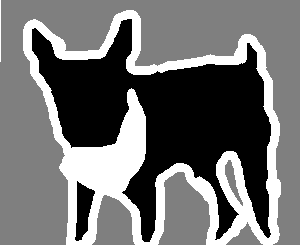

In [157]:
# Display input image #7
image = Image(filename=test_input_img_paths[0])
display(image)
# Display auto-contrast version of corresponding target (per-pixel categories)
mask = ImageOps.autocontrast(load_img(test_target_img_paths[0]))
display(mask)

In [79]:
from keras import Model

In [80]:
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[layer_number[0]].output)

In [85]:
from matplotlib import image

In [90]:
im = image.imread(test_input_img_paths[50])
im = np.expand_dims(im, axis=0)
im.shape

(1, 333, 500, 3)

In [97]:
img = test_gen[0][0][0]
test_gen[0][0][0].shape
img = np.expand_dims(img, axis=0)

In [98]:
feature_maps = model.predict(img)

1/1 [==============================] - 0s 107ms/step


In [99]:
from matplotlib import pyplot

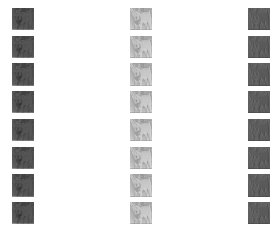

In [105]:
# plot all 64 maps in an 8x8 squares
n_fliters = 8
ix = 1
for _ in range(n_fliters):
    f = feature_maps[:, :, :, ix]
    for h in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_fliters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, h], cmap='gray')
        ix += 1
  # show the figure
pyplot.show()

In [ ]:
outputs = [model.layers[i-1].output for i in layer_number]
model = Model(inputs=model.inputs, outputs=outputs)
model.summary()

In [164]:
len(outputs)

51

In [166]:
feature_maps = model.predict(img)

1/1 [==============================] - 3s 3s/step


In [168]:
len(feature_maps)

51

In [176]:
i=0
for fmap in feature_maps:
  i+=1
  print(fmap.shape)

print(i)

(1, 80, 80, 32)
(1, 160, 160, 32)
(1, 80, 80, 32)
(1, 160, 160, 32)
(1, 80, 80, 32)
(1, 40, 40, 64)
(1, 80, 80, 64)
(1, 40, 40, 64)
(1, 80, 80, 64)
(1, 40, 40, 64)
(1, 20, 20, 128)
(1, 40, 40, 128)
(1, 20, 20, 128)
(1, 40, 40, 128)
(1, 20, 20, 128)
(1, 10, 10, 256)
(1, 20, 20, 256)
(1, 10, 10, 256)
(1, 20, 20, 256)
(1, 10, 10, 256)
(1, 5, 5, 512)
(1, 10, 10, 512)
(1, 5, 5, 512)
(1, 10, 10, 512)
(1, 10, 10, 256)
(1, 10, 10, 256)
(1, 1, 1, 256)
(1, 10, 10, 256)
(1, 10, 10, 256)
(1, 10, 10, 256)
(1, 20, 20, 256)
(1, 10, 10, 256)
(1, 20, 20, 256)
(1, 10, 10, 256)
(1, 20, 20, 256)
(1, 40, 40, 128)
(1, 20, 20, 128)
(1, 40, 40, 128)
(1, 20, 20, 128)
(1, 40, 40, 128)
(1, 80, 80, 64)
(1, 40, 40, 64)
(1, 80, 80, 64)
(1, 40, 40, 64)
(1, 80, 80, 64)
(1, 160, 160, 32)
(1, 80, 80, 32)
(1, 160, 160, 32)
(1, 80, 80, 32)
(1, 160, 160, 32)
(1, 160, 160, 3)
51


1


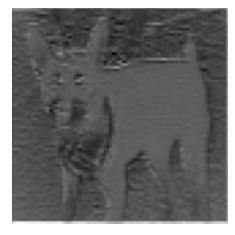

2


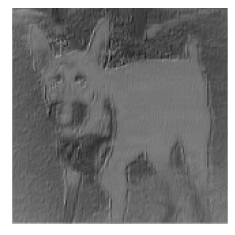

3


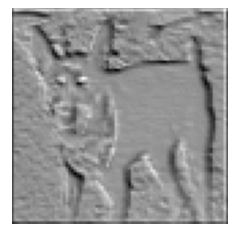

4


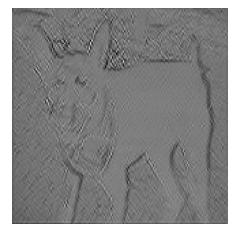

5


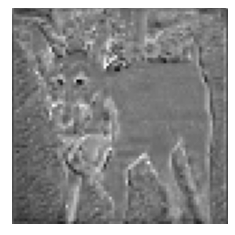

6


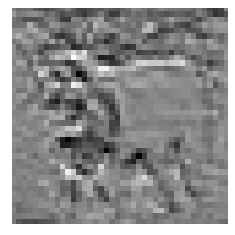

7


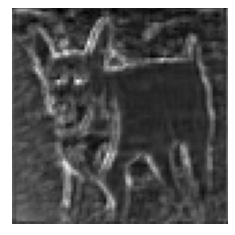

8


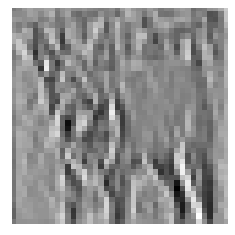

9


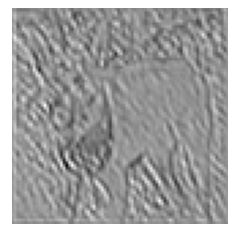

10


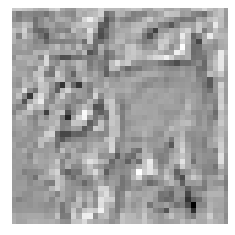

11


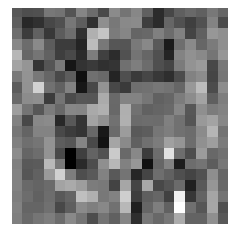

12


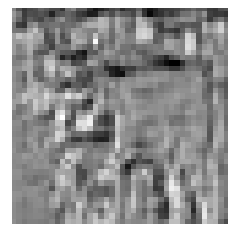

13


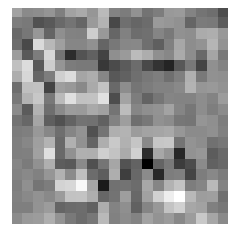

14


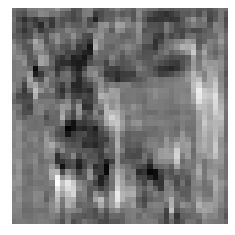

15


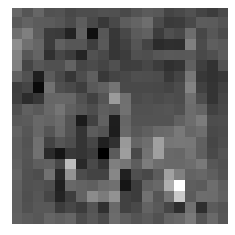

16


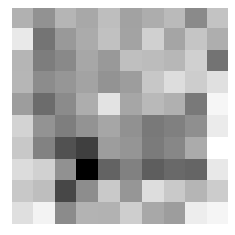

17


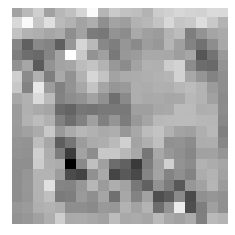

18


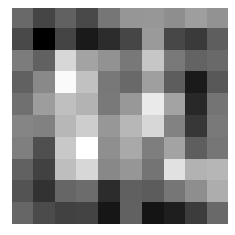

19


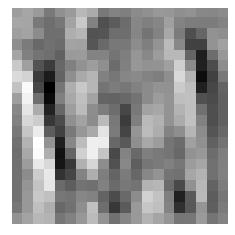

20


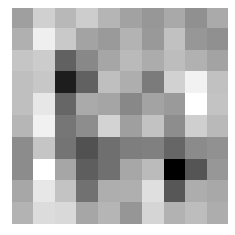

21


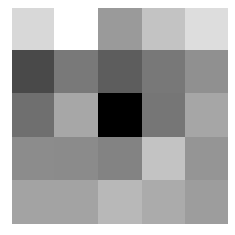

22


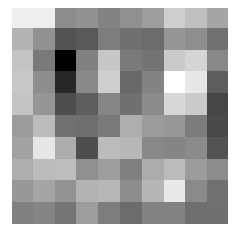

23


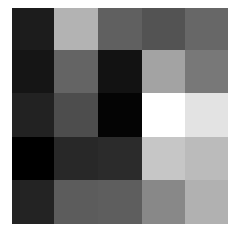

24


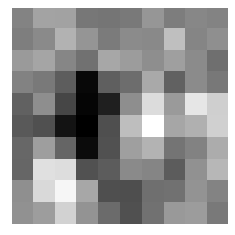

25


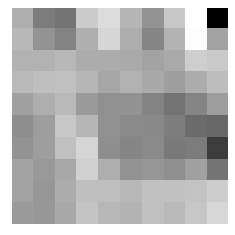

26


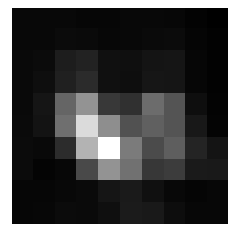

27


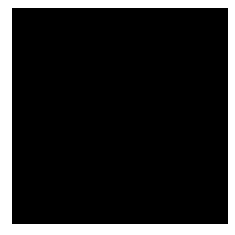

28


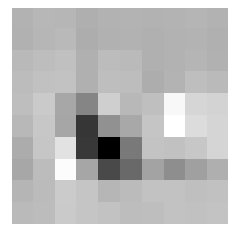

29


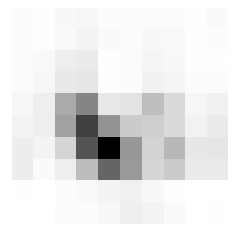

30


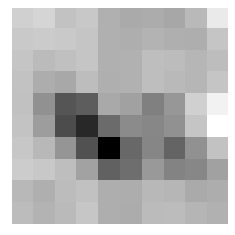

31


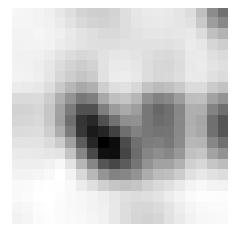

32


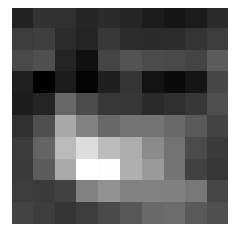

33


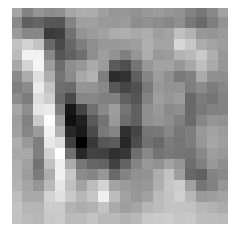

34


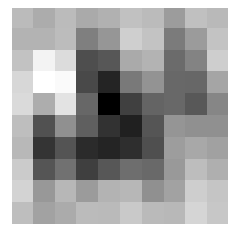

35


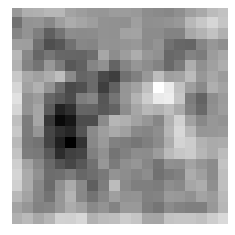

36


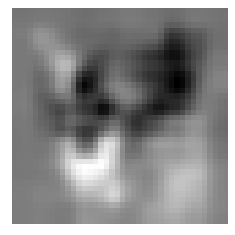

37


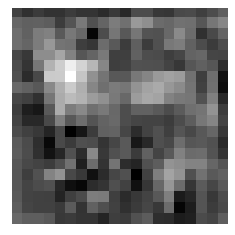

38


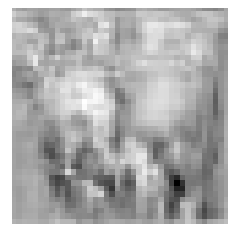

39


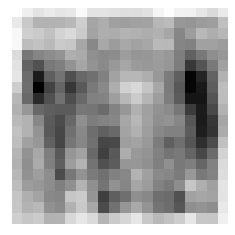

40


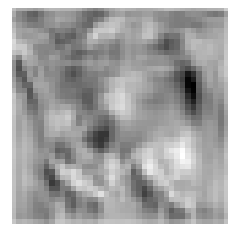

41


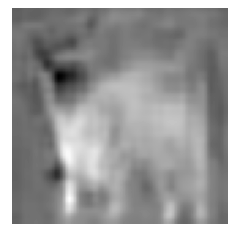

42


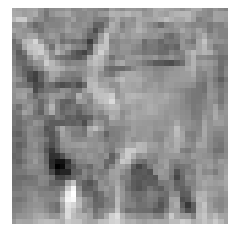

43


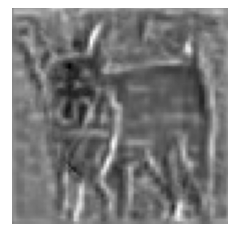

44


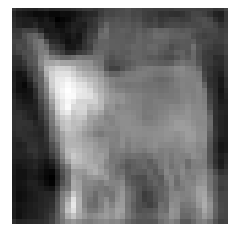

45


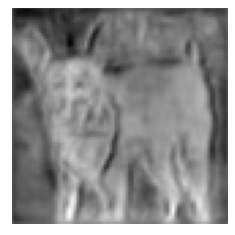

46


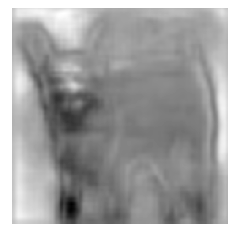

47


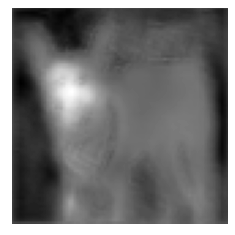

48


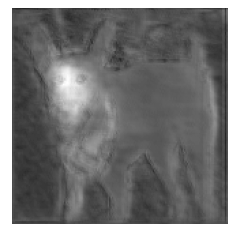

49


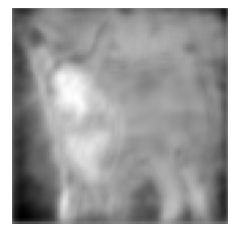

50


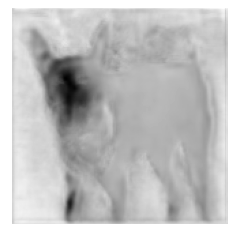

51


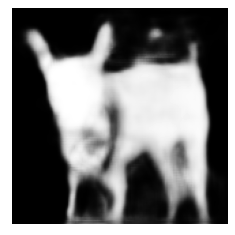

In [183]:
square = 1
j = 0
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
          # specify subplot and turn of axis
          ax = pyplot.subplot(square, square, ix)
          ax.set_xticks([])
          ax.set_yticks([])
          # plot filter channel in grayscale
          pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
          ix += 1
    # show the figure
    j += 1
    print(j)
    pyplot.show()